### 3 Visualization - Prediction Confidence Heatmaps

A sliding window approach was applied on the whole slide images (WSIs) with the trained CNN model to generate confidence heatmaps. 

The WSIs were tiled into 1536 x 1536 images patches in the prepocessing steps. A sliding window approached was applied on evey image patch of a WSI. At each time, the CNN model took a 256x256 pixels region as input, forward propagated and generated a prediction score for cored plaque, diffuse plaque and CAA respectively. By systematically sliding the input region across the entire 1536 x 1536 image patch, the prediction scores were saved and ploted as prediction confidence heatmap for this patch. The heatmap for the WSI was obtained by doing this on all image patches of it.

In [8]:
import time, os, glob

import torch
torch.manual_seed(123456789)
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
from tqdm import tqdm
import copy

print(torch.__version__, torchvision.__version__)

1.4.0 0.5.0


In [9]:
IMG_DIR  = 'data/norm_tiles/'
MODEL_DIR = 'models/CNN_model_parameters.pkl'
SAVE_DIR = 'data/outputs/heatmaps/'

# Brainseg
MODEL_DIR = 'models/ResNet18_19.pkl'
SAVE_IMG_DIR = 'data/brainseg/images/'
SAVE_NP_DIR = 'data/brainseg/numpy/'

In [10]:
if not os.path.exists(SAVE_DIR):
        os.makedirs(SAVE_DIR)

In [57]:
img_size = 1536
stride = 16
batch_size = 32 # 1 for Brainseg, 64 for plaquebox
num_workers = 16

norm = np.load('utils/normalization.npy', allow_pickle=True).item() # plaquebox
norm = np.load('norm_brainseg/normalization.npy', allow_pickle=True).item() # brainseg
normalize = transforms.Normalize(norm['mean'], norm['std'])
to_tensor = transforms.ToTensor()
use_gpu = torch.cuda.is_available()

filenames = glob.glob(IMG_DIR + '*')
filenames = [filename.split('/')[-1] for filename in filenames]
filenames = sorted(filenames)
print(filenames)

['NA3777-02_AB', 'NA4077-02_AB', 'NA4092-02_AB', 'NA4107-02_AB', 'NA4160-02_AB', 'NA4195-02_AB', 'NA4256-02_AB', 'NA4299-02_AB', 'NA4391-02_AB', 'NA4450-02_AB', 'NA4463-02_AB', 'NA4471-02_AB', 'NA4553-02_AB', 'NA4626-02_AB', 'NA4672-02_AB', 'NA4675-02_AB', 'NA4691-02_AB', 'NA4695-02_AB']


In [58]:
from torch.utils.data import Dataset

class HeatmapDataset(Dataset):
    def __init__(self, tile_dir, row, col, stride=1):
        """
        Args:
            tile_dir (string): path to the folder where tiles are
            row (int): row index of the tile being operated
            col (int): column index of the tile being operated
            stride: stride of sliding 
        """
        self.tile_size = 256
        self.img_size = 1536
        self.stride = stride
        padding = 128
        large_img = torch.ones(3, 3*self.img_size, 3*self.img_size)
        
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                img_path = tile_dir+'/'+str(row+i)+'/'+str(col+j)+'.jpg'
                try:
                    img = Image.open(img_path)
                    img = transforms.ToTensor()(img) 
                except:
                    img = torch.ones(3,self.img_size, self.img_size)
                
                large_img[:, (i+1)*self.img_size:(i+2)*self.img_size,(j+1)*self.img_size:(j+2)*self.img_size] = img
        
        large_img = normalize(large_img)
        
        self.padding_img = large_img[:,self.img_size-padding:2*self.img_size+padding, self.img_size-padding:2*self.img_size+padding]
        self.len = (self.img_size//self.stride)**2
        
    def __getitem__(self, index):

        row = (index*self.stride // self.img_size)*self.stride
        col = (index*self.stride % self.img_size)

        img = self.padding_img[:, row:row+self.tile_size, col:col+self.tile_size]        
    
        return img

    def __len__(self):
        return self.len

In [59]:
class Net(nn.Module):

    def __init__(self, fc_nodes=512, num_classes=3, dropout=0.5):
        super(Net, self).__init__()
        
    def forward(self, x):
 
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)

        return x


In [60]:
# instatiate the model
model = torch.load(MODEL_DIR, map_location=lambda storage, loc: storage)

if use_gpu:
    model = model.cuda()
#     model = model.module.cuda() # Plaquebox-paper
else:
    model = model
#     model = model.module

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 256, 256])
288


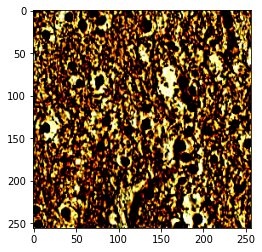

In [64]:
TILE_DIR = IMG_DIR+'{}/0/'.format('NA3777-02_AB')

image_datasets = HeatmapDataset(TILE_DIR, 12, 13, stride=stride)
dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,
                                        shuffle=False, num_workers=num_workers)
print(dataloader)
nextData = iter(dataloader)
nextData = next(nextData)
print(nextData[0].shape)
print(len(dataloader))

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

img_np = np.asarray(nextData)
# print(img_np[0,:,:,:].shape)
# print(np.squeeze(img_np, axis=0).shape)
# img_np = np.squeeze(img_np, axis=0)
img_np = img_np[0,:,:,:]
img_np = np.transpose(img_np, (1, 2, 0))
fig = plt.figure()
imgFig = plt.imshow(img_np)
fig.show()

In [ ]:
def saveBrainSegImage(nums, save_dir) :
    # Converts 2D array with {0,1,2} into RGB
    # to determine different segmentation areas
    # and saves image at given directory
    #
    # Input:
    #   nums: 2D-NumPy Array containing classification
    #   save_dir: string indicating save location
    
    nums = np.repeat(nums[:,:, np.newaxis], 3, axis=2)
    
    # nums[:,:,0] = RED, nums[:,:,1] = Green, nums[:,:,2] = Blue
    idx_1 = np.where(nums[:,:,0] == 2)  # Index of label 1 (WM)
    idx_2 = np.where(nums[:,:,0] == 1)  # Index of label 2 (GM)

    # For label 0, leave as black color
    # For label 1, set to cyan color: R0G255B255
    nums[:,:,0].flat[np.ravel_multi_index(idx_1, nums[:,:,0].shape)] = 0
    nums[:,:,1].flat[np.ravel_multi_index(idx_1, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_1, nums[:,:,2].shape)] = 255
    # For label 2, set to yellow color: R255G255B0
    nums[:,:,0].flat[np.ravel_multi_index(idx_2, nums[:,:,0].shape)] = 255
    nums[:,:,1].flat[np.ravel_multi_index(idx_2, nums[:,:,1].shape)] = 255
    nums[:,:,2].flat[np.ravel_multi_index(idx_2, nums[:,:,2].shape)] = 0

    save_img = Image.fromarray(nums, 'RGB')
    save_img.save(save_dir)
    print("Saved at: " + save_dir)
    

In [23]:
import time

In [ ]:
for filename in filenames:
    TILE_DIR = IMG_DIR+'{}/0/'.format(filename)

    imgs = []
    for target in sorted(os.listdir(TILE_DIR)):
        d = os.path.join(TILE_DIR, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if fname.endswith('.jpg'):
                    path = os.path.join(root, fname)
                    imgs.append(path)

    rows = [int(image.split('/')[-2]) for image in imgs]
    row_nums = max(rows) + 1
    cols = [int(image.split('/')[-1].split('.')[0]) for image in imgs]
    col_nums = max(cols) +1    
    
    heatmap_res = img_size // stride
    final_output = np.zeros((heatmap_res*row_nums, heatmap_res*col_nums))

    model.train(False)  # Set model to evaluate mode
    
    start_time = time.perf_counter()

    for row in tqdm(range(row_nums)):
        for col in range(col_nums):

            image_datasets = HeatmapDataset(TILE_DIR, row, col, stride=stride)
            dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,
                                                 shuffle=False, num_workers=num_workers)

#             running_preds = torch.Tensor(0)
#             running_value = torch.ByteTensor(0)
            running_value = torch.zeros((32), dtype=torch.uint8)
            output_class = np.zeros((img_size//stride, img_size//stride))
            
            for idx, data in enumerate(dataloader):
                # get the inputs
                inputs = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda(), volatile=True)
                    # forward
                    predict = model(inputs)
#                     print(predict.shape)
                    _, indices = torch.max(predict.data, 1) # indices = 0:Background, 1:WM, 2:GM
                    indices = indices.type(torch.uint8)
                    indices =  indices.data.cpu()
#                     print(idx)
#                     print(type(data))
#                     print(indices.shape)
                    running_value = np.asarray(indices, dtype=np.uint8)
    
    
#                     i = (idx // (img_size//stride))
#                     j = (idx % (img_size//stride))
#                     print(running_value)
                    i = (idx // (img_size//stride))
                    j = (idx % 3)
                    output_class[i,j*32:(j+1)*32] = running_value
#                     running_value = torch.cat([running_value, indices])
                    
#                     preds = F.sigmoid(outputs) #posibility for each class
#                     preds = preds.data.cpu()
#                     running_preds = torch.cat([running_preds, preds])

            
#             print(running_value.shape)
#             output_class = np.asarray(running_value).reshape(img_size//stride, img_size//stride)
            
#             cored = np.asarray(running_preds[:,0]).reshape(img_size//stride,img_size//stride)
#             diffuse = np.asarray(running_preds[:,1]).reshape(img_size//stride,img_size//stride)
#             caa = np.asarray(running_preds[:,2]).reshape(img_size//stride,img_size//stride)

            final_output[row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = output_class
#             final_output[0, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = cored
#             final_output[1, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = diffuse
#             final_output[2, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = caa

    np.save(SAVE_NP_DIR+filename, final_output)
    saveBrainSegImage(final_output, \
                      SAVE_IMG_DIR + filename + '.png')
    
    # Time Statistics
    end_time = time.perf_counter()
    print("Time to process " \
          + filename \
          + ": ", end_time-start_time, "sec")

  0%|          | 0/31 [00:00<?, ?it/s]

Saved at: data/brainseg/images/NA3777-02_AB.png
Time to process NA3777-02_AB:  16037.008783468045 sec


  0%|          | 0/30 [00:00<?, ?it/s]

Saved at: data/brainseg/images/NA4077-02_AB.png
Time to process NA4077-02_AB:  21407.49149317667 sec


 70%|███████   | 21/30 [3:37:06<1:33:14, 621.63s/it]

In [79]:
print(output_class[i,j*32:(j+1)*32].shape)
print(img_size // stride)
print(len(dataloader))
print(96*96)
print(3*96)

(32,)
96
288
9216
288


In [ ]:
np.

In [41]:
print(filename)

NA3777-02_AB


In [32]:
print(final_output)

[[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:
for filename in filenames:
    TILE_DIR = IMG_DIR+'{}/0/'.format(filename)

    imgs = []
    for target in sorted(os.listdir(TILE_DIR)):
        d = os.path.join(TILE_DIR, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if fname.endswith('.jpg'):
                    path = os.path.join(root, fname)
                    imgs.append(path)

    rows = [int(image.split('/')[-2]) for image in imgs]
    row_nums = max(rows) + 1
    cols = [int(image.split('/')[-1].split('.')[0]) for image in imgs]
    col_nums = max(cols) +1    
    
    heatmap_res = img_size // stride
    final_output = np.zeros((3, heatmap_res*row_nums, heatmap_res*col_nums))

    model.train(False)  # Set model to evaluate mode

    for row in tqdm(range(row_nums)):
        for col in range(col_nums):

            image_datasets = HeatmapDataset(TILE_DIR, row, col, stride=stride)
            dataloader = torch.utils.data.DataLoader(image_datasets, batch_size=batch_size,
                                                 shuffle=False, num_workers=num_workers)

            running_preds = torch.Tensor(0)
            for data in dataloader:
                # get the inputs
                inputs = data
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda(), volatile=True)
                    # forward
                    outputs = model(inputs)
                    preds = F.sigmoid(outputs) #posibility for each class
                    preds = preds.data.cpu()
                    running_preds = torch.cat([running_preds, preds])

            cored = np.asarray(running_preds[:,0]).reshape(img_size//stride,img_size//stride)
            diffuse = np.asarray(running_preds[:,1]).reshape(img_size//stride,img_size//stride)
            caa = np.asarray(running_preds[:,2]).reshape(img_size//stride,img_size//stride)

            final_output[0, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = cored
            final_output[1, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = diffuse
            final_output[2, row*heatmap_res:(row+1)*heatmap_res, col*heatmap_res:(col+1)*heatmap_res] = caa

    np.save(SAVE_DIR+filename, final_output)

NameError: name 'final_output' is not defined

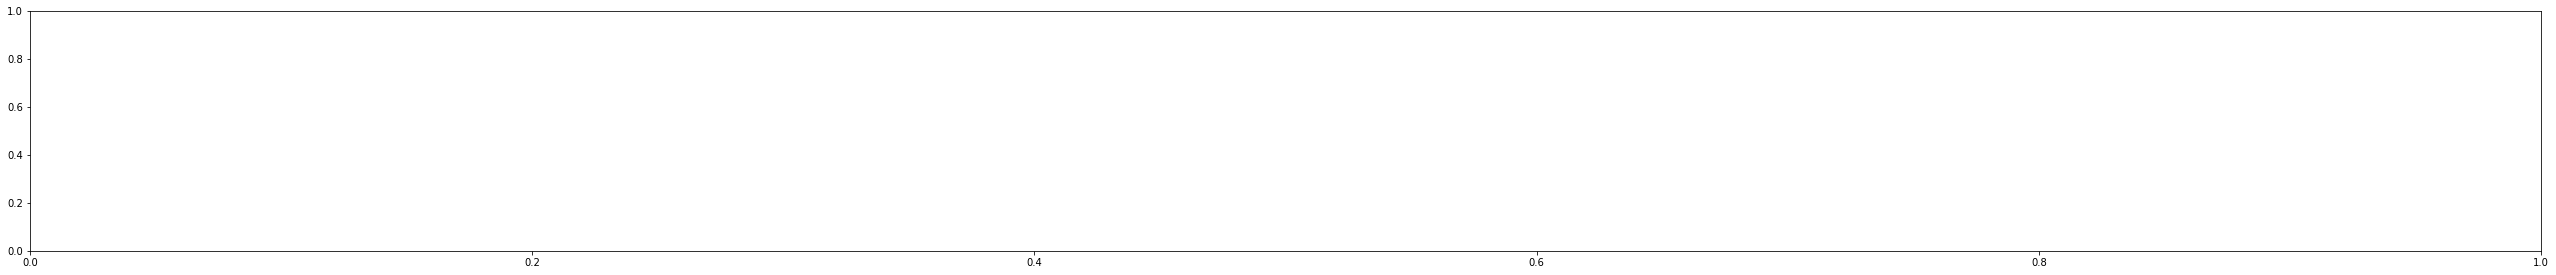

In [24]:
fig = plt.figure(figsize=(45,15))
    
ax = fig.add_subplot(311)

im = ax.imshow(final_output[0], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

ax = fig.add_subplot(312)

im = ax.imshow(final_output[1], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])

ax = fig.add_subplot(313)

im = ax.imshow(final_output[2], cmap=plt.cm.get_cmap('viridis', 20), vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, ticks=[0.0, 0.25, 0.5, 0.75, 1.0])